## Import Necessary Packages

In [4]:
import os
import json
import warnings
import numpy as np
import xarray as xr
import proplot as pplt
pplt.rc['reso']='xx-hi'
pplt.rc['figure.dpi'] = 100
warnings.filterwarnings('ignore')

## User-Defined Fields

In [5]:
CONFIGSPATH = '/global/cfs/cdirs/m4334/sferrett/monsoon-sr/src/losses/configs.json'
with open(CONFIGSPATH,'r',encoding='utf-8') as f:
    CONFIGS = json.load(f)

FILEDIR    = CONFIGS['paths']['filedir']      
MODELDIR   = CONFIGS['paths']['modeldir']    
RESULTSDIR = CONFIGS['paths']['resultsdir']  
RUNS       = CONFIGS['runs']
SPLIT      = 'valid'
PRTHRESH   = 0.01

## Functions

In [6]:
def get_r2(ytrue,ypred,dims=None,fillnan=None):
    if fillnan is None:
        ypred = ypred
    elif fillnan=='mean':
        ypred = ypred.fillna(float(ytrue.mean(skipna=True)))
    else:
        ypred = ypred.fillna(float(fillnan))
    if dims is None:
        dims = list(ytrue.dims)
    mu  = ytrue.mean(dim=dims,skipna=True)
    rss = ((ypred-ytrue)**2).sum(dim=dims,skipna=True)
    tss = ((ytrue-mu)**2).sum(dim=dims,skipna=True)
    r2  = 1.0- (rss/tss)
    return float(r2) if not r2.dims else r2

## Load Data

In [7]:
truepath = os.path.join(FILEDIR,f'{SPLIT}.h5')
with xr.open_dataset(truepath,engine='h5netcdf') as ds:
    truepr = ds['pr'].load()

results = {}
for run in RUNS:
    runtype     = run['run_type']
    runname     = run['run_name']
    description = run.get('description',runname)
    predpath    = os.path.join(RESULTSDIR,f'{runtype}_{runname}_{SPLIT}_pr.nc')
    with xr.open_dataset(predpath,engine='h5netcdf') as ds:
        predpr = ds['pr'].load()
    ytrue,ypred= xr.align(truepr,predpr,join='inner')
    results[runname] = dict(description=description,ytrue=ytrue,ypred=ypred)

## P-$B_L$ Relationships

In [8]:
# curves = []
# for run in RUNS:
#     runtype  = run['run_type']
#     if runtype=='pod':
#         runname     = run['run_name']
#         description = run.get('description',runname)
#         npzpath     = os.path.join(MODELDIR,f'{runtype}_{runname}.npz')
#         with np.load(npzpath) as data:
#             bincenters = data['bincenters'].astype(np.float32)
#             binmeans   = data['binmeans'].astype(np.float32)
#             nparams    = int(np.isfinite(binmeans).sum())
#         curves.append(dict(runname=runname,description=description,bincenters=bincenters,binmeans=binmeans,nparams=nparams))

In [9]:
# fig,axs = pplt.subplots(nrows=2,ncols=3,refwidth=2,share=True)
# for i,curve in enumerate(curves):
#     mask = np.isfinite(curve['binmeans'])
#     axs[i].scatter(curve['bincenters'][mask],curve['binmeans'][mask],color='red6',marker='x',alpha=0.5)
#     axs[i].format(title=curve['description'])
#     axs[i].text(0.05,0.95,f'Parameters = {curve["nparams"]}',transform=axs[i].transAxes,va='top')
# axs.format(suptitle='P-$\mathit{B_L}$ Relationships',xlabel='$\mathit{B_L}$ (m/s$^{2}$)',ylabel='Precipitation (mm/hr)')
# pplt.show()

## 1D Distribution Comparison

In [10]:
binedges  = np.linspace(0,120,60)

paneldata = [] 
for runname,result in results.items():
    description = result['description']
    ytrue = result['ytrue']
    ypred = result['ypred']
    mask  = np.isfinite(ytrue)&(ytrue>PRTHRESH)
    r2    = get_r2(ytrue.where(mask),ypred.where(mask),dims=None,fillnan=None)    
    ytrueflat = ytrue.where(mask).values.ravel()
    ypredflat = ypred.where(mask).values.ravel()
    paneldata.append((description,r2,ytrueflat,ypredflat))

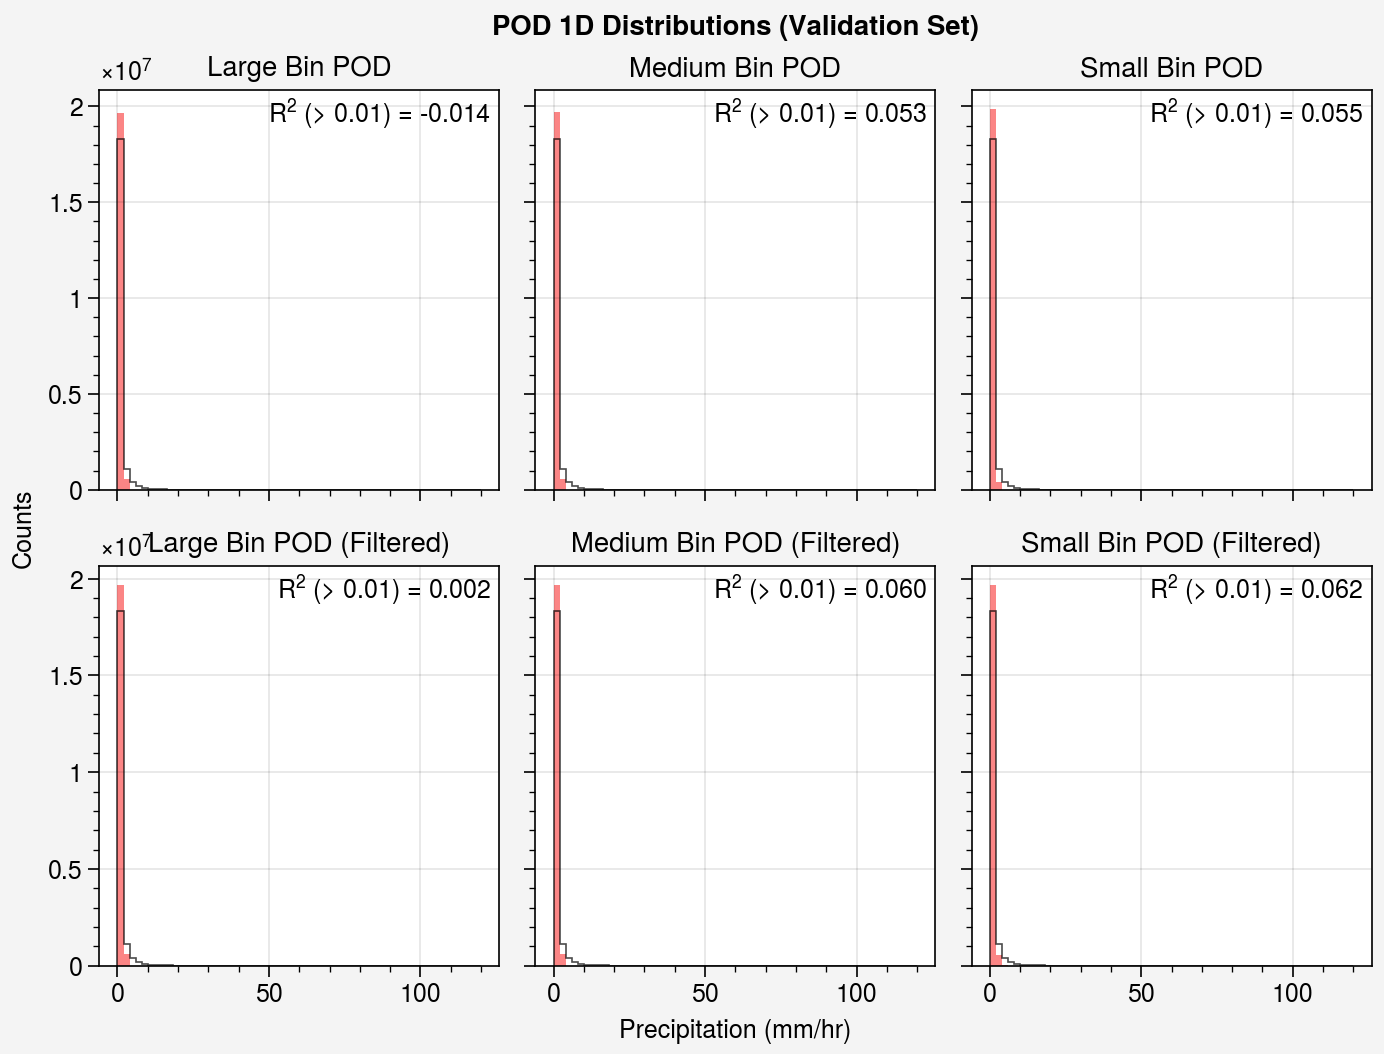

In [11]:
podpaneldata = [t for t in paneldata if 'pod' in t[0].lower()]

fig, axs = pplt.subplots(nrows=2,ncols=3,refwidth=2,share=True)
axs.format(suptitle='POD 1D Distributions (Validation Set)',xlabel='Precipitation (mm/hr)',ylabel='Counts')

for ax,(description,r2,ytrueflat,ypredflat) in zip(axs,podpaneldata):
    ax.hist(ytrueflat,bins=binedges,histtype='step',color='k',alpha=0.7)
    ax.hist(ypredflat,bins=binedges,color='red6',alpha=0.7)
    ax.text(0.98,0.98,f'R$^2$ (> 0.01) = {r2:.3f}',transform=ax.transAxes,va='top',ha='right')
    ax.format(title=description)

pplt.show()

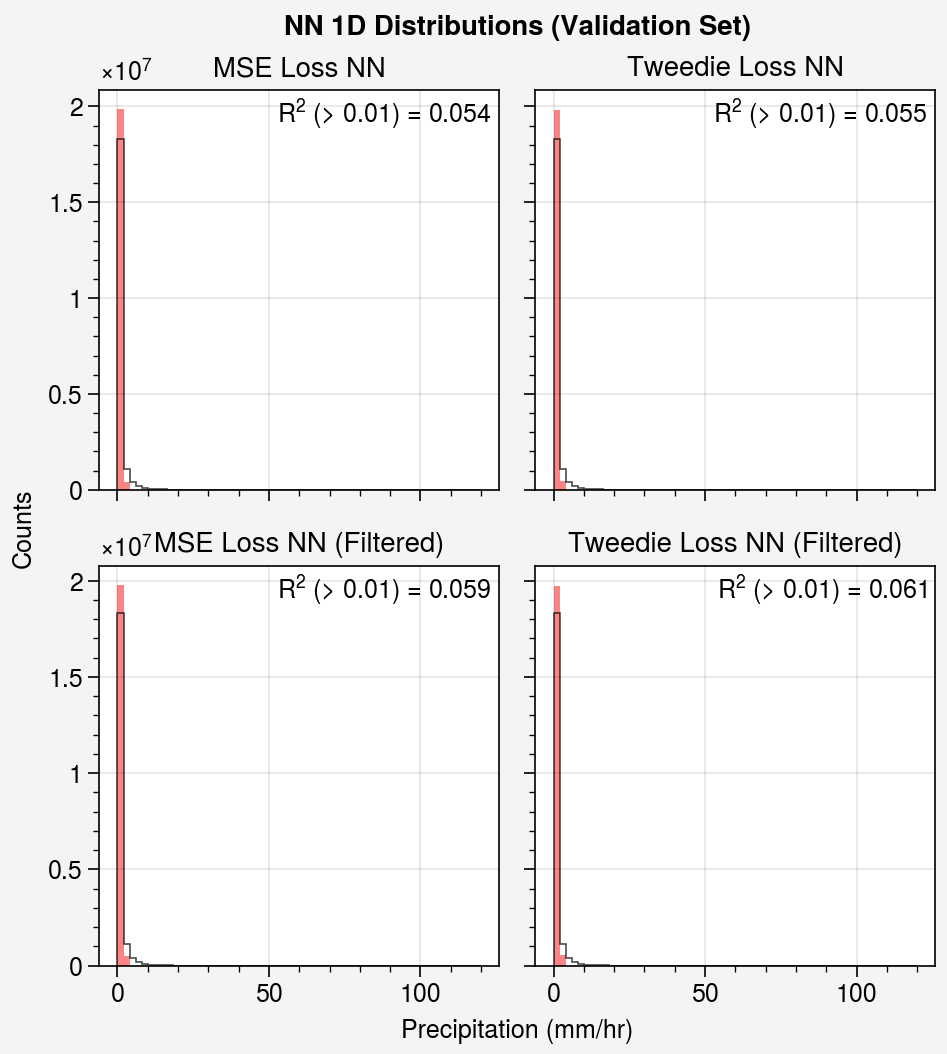

In [12]:
nnpaneldata = [t for t in paneldata if 'nn' in t[0].lower()]

fig,axs = pplt.subplots(nrows=2,ncols=2,refwidth=2,share=True)
axs.format(suptitle='NN 1D Distributions (Validation Set)',xlabel='Precipitation (mm/hr)',ylabel='Counts')

for ax,(description,r2,ytrueflat,ypredflat) in zip(axs,nnpaneldata):
    ax.hist(ytrueflat,bins=binedges,histtype='step',color='k',alpha=0.7)
    ax.hist(ypredflat,bins=binedges,color='red6',alpha=0.7)
    ax.text(0.98,0.98,f'R$^2$ (> 0.01) = {r2:.3f}',transform=ax.transAxes,va='top',ha='right')
    ax.format(title=description)

pplt.show()

## 2D Distribution Comparison

In [13]:
globalmin = 0
globalmax = 120
binedges  = np.linspace(globalmin,globalmax,60)

paneldata = []
for runname,result in results.items():
    description = result['description']
    ytrue = result['ytrue']
    ypred = result['ypred']
    mask  = np.isfinite(ytrue)&(ytrue>PRTHRESH)
    r2    = get_r2(ytrue.where(mask),ypred.where(mask),dims=None,fillnan=None)
    ytrueflat = ytrue.where(mask).values.ravel()
    ypredflat = ypred.where(mask).values.ravel()
    hist,_,_ = np.histogram2d(ytrueflat,ypredflat,bins=[binedges,binedges])
    hist = np.ma.masked_where(hist==0,hist)
    paneldata.append((description,hist,r2))

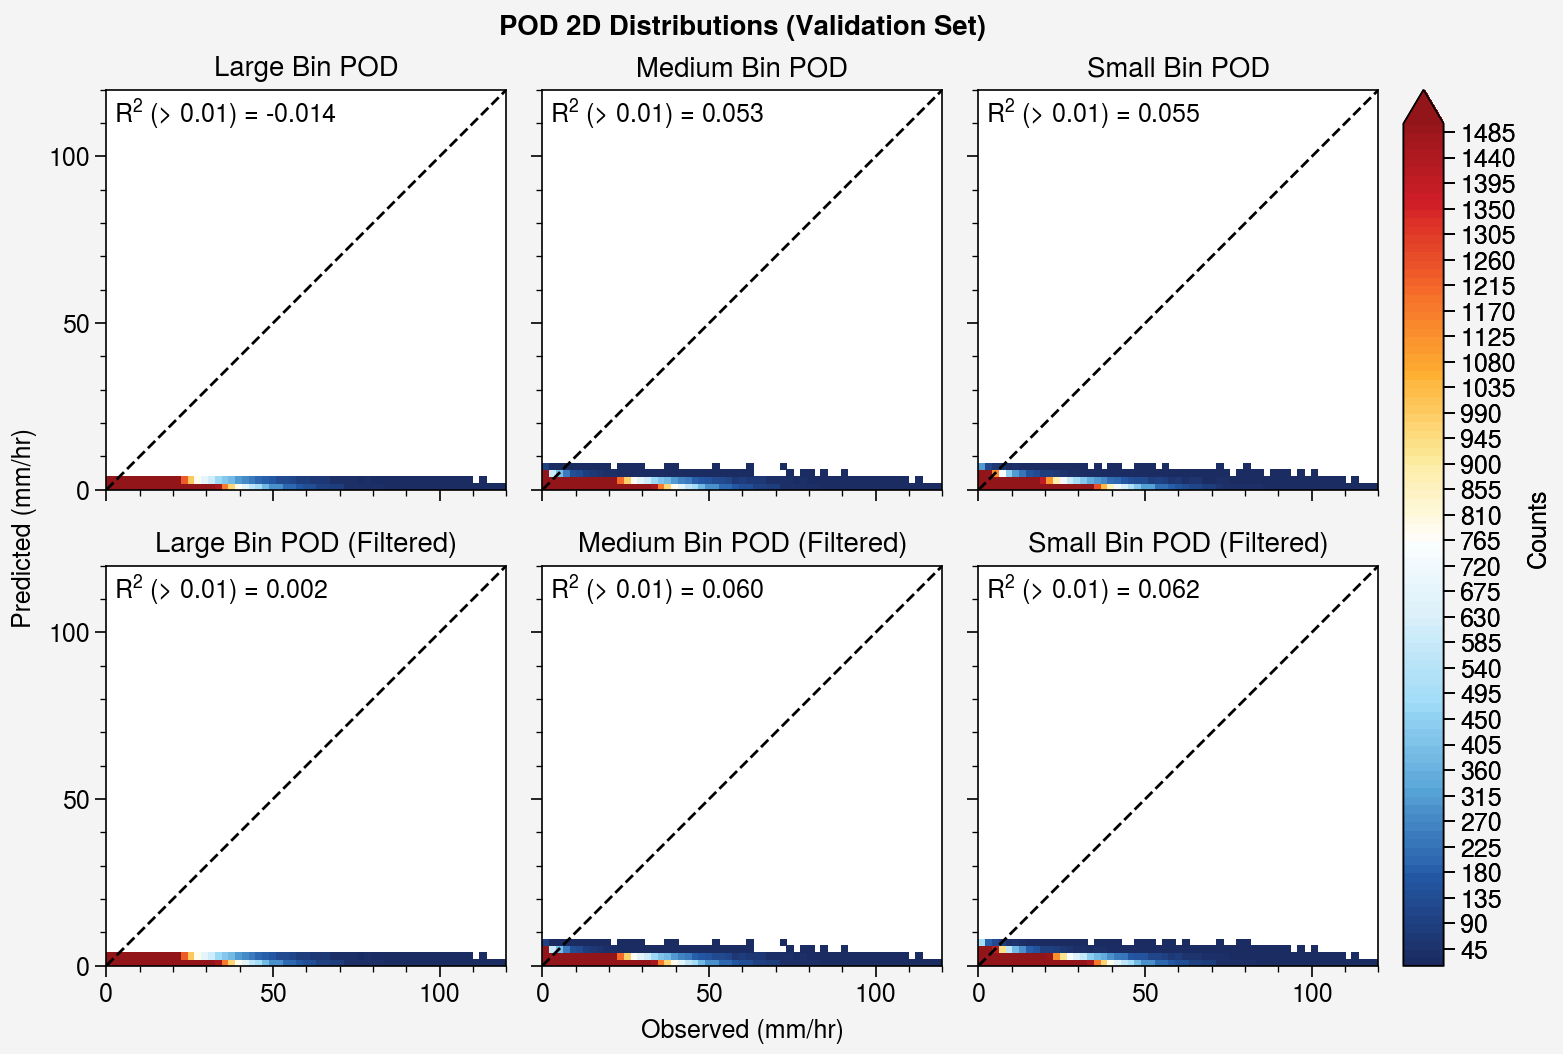

In [16]:
podpaneldata = [t for t in paneldata if 'pod' in t[0].lower()]

fig,axs = pplt.subplots(nrows=2,ncols=3,refwidth=2,share=True)
axs.format(suptitle='POD 2D Distributions (Validation Set)',xlabel='Observed (mm/hr)',ylabel='Predicted (mm/hr)')

im = None
for ax,(description,hist,r2) in zip(axs,podpaneldata):
    im = ax.pcolormesh(binedges,binedges,hist.T,cmap='ColdHot',vmin=1,vmax=1500,levels=100,extend='max')
    ax.plot([globalmin,globalmax],[globalmin,globalmax],color='k',linewidth=1,linestyle='--')
    ax.text(0.02,0.98,f'R$^2$ (> 0.01) = {r2:.3f}',transform=ax.transAxes,va='top',ha='left')
    ax.format(title=description,xlim=(globalmin,globalmax),xticks=50,ylim=(globalmin,globalmax),yticks=50)

fig.colorbar(im,loc='r',label='Counts')
pplt.show()

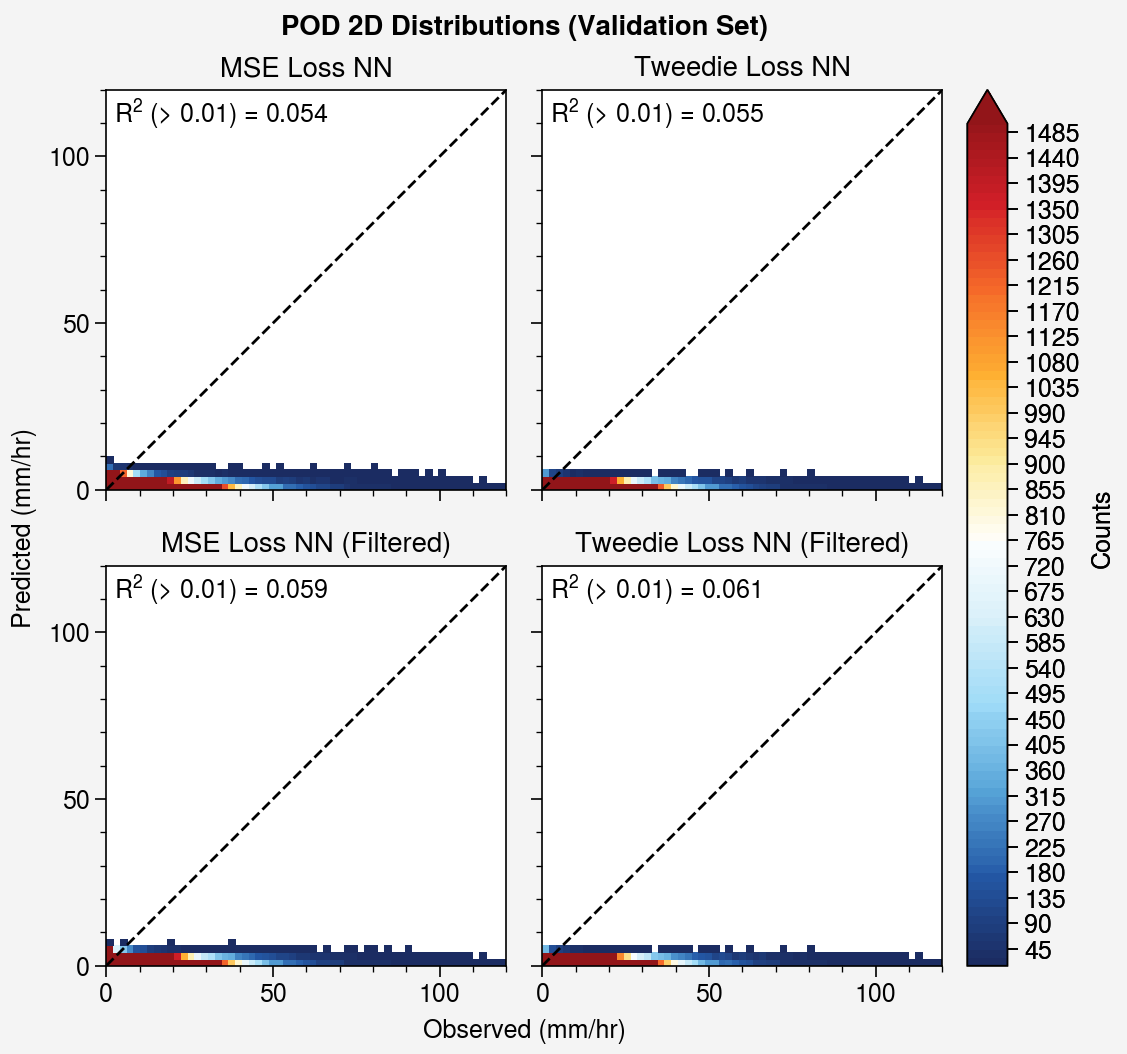

In [17]:
nnpaneldata = [t for t in paneldata if 'nn' in t[0].lower()]

fig,axs = pplt.subplots(nrows=2,ncols=2,refwidth=2,share=True)
axs.format(suptitle='POD 2D Distributions (Validation Set)',xlabel='Observed (mm/hr)',ylabel='Predicted (mm/hr)')

im = None
for ax,(description,hist,r2) in zip(axs,nnpaneldata):
    im = ax.pcolormesh(binedges,binedges,hist.T,cmap='ColdHot',vmin=1,vmax=1500,levels=100,extend='max')
    ax.plot([globalmin,globalmax],[globalmin,globalmax],color='k',linewidth=1,linestyle='--')
    ax.text(0.02,0.98,f'R$^2$ (> 0.01) = {r2:.3f}',transform=ax.transAxes,va='top',ha='left')
    ax.format(title=description,xlim=(globalmin,globalmax),xticks=50,ylim=(globalmin,globalmax),yticks=50)

fig.colorbar(im,loc='r',label='Counts')
pplt.show()

## $\mathrm{R^2}$ Maps

In [21]:
paneldata = []
for runname,result in results.items():
    description = result['description']
    ytrue = result['ytrue']
    ypred = result['ypred']
    mask  = np.isfinite(ytrue)&(ytrue>PRTHRESH)
    r2    = get_r2(ytrue.where(mask),ypred.where(mask),dims=['time'],fillnan=None)
    paneldata.append((description,r2))

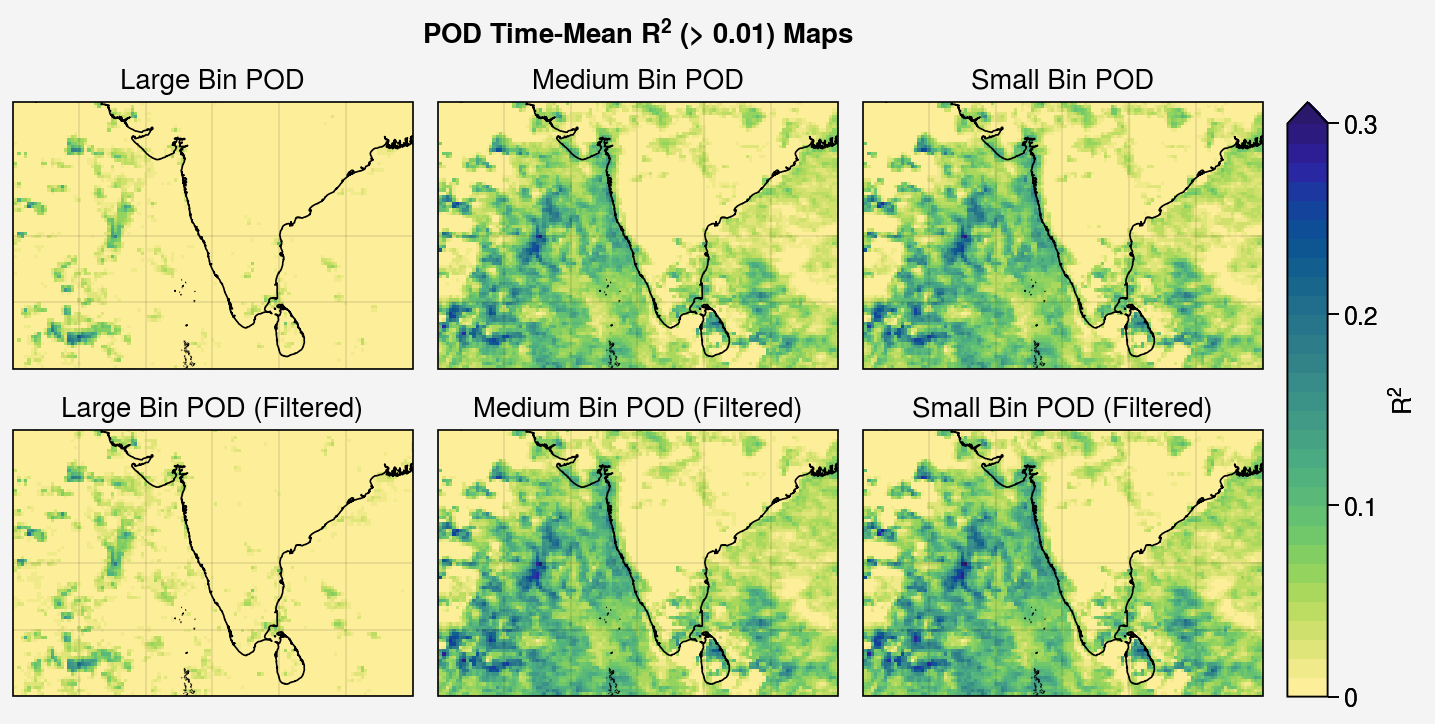

In [30]:
podpaneldata = [t for t in paneldata if 'pod' in t[0].lower()]

fig,axs = pplt.subplots(nrows=2,ncols=3,refwidth=2,proj='cyl',share=False)
axs.format(suptitle=f'POD Time-Mean R$^2$ (> 0.01) Maps',
           coast=True,latlim=(5.,25.),latlines=[5,10,15],lonlim=(60.,90.),lonlines=5)

im = None
for i,(description,r2) in enumerate(podpaneldata):
    im = axs[i].pcolormesh(r2.lon,r2.lat,r2,cmap='Haline_r',vmin=0,vmax=0.3,levels=30,extend='max')
    axs[i].format(title=description)

fig.colorbar(im,loc='r',label='R$^2$',ticks=0.1)
pplt.show()

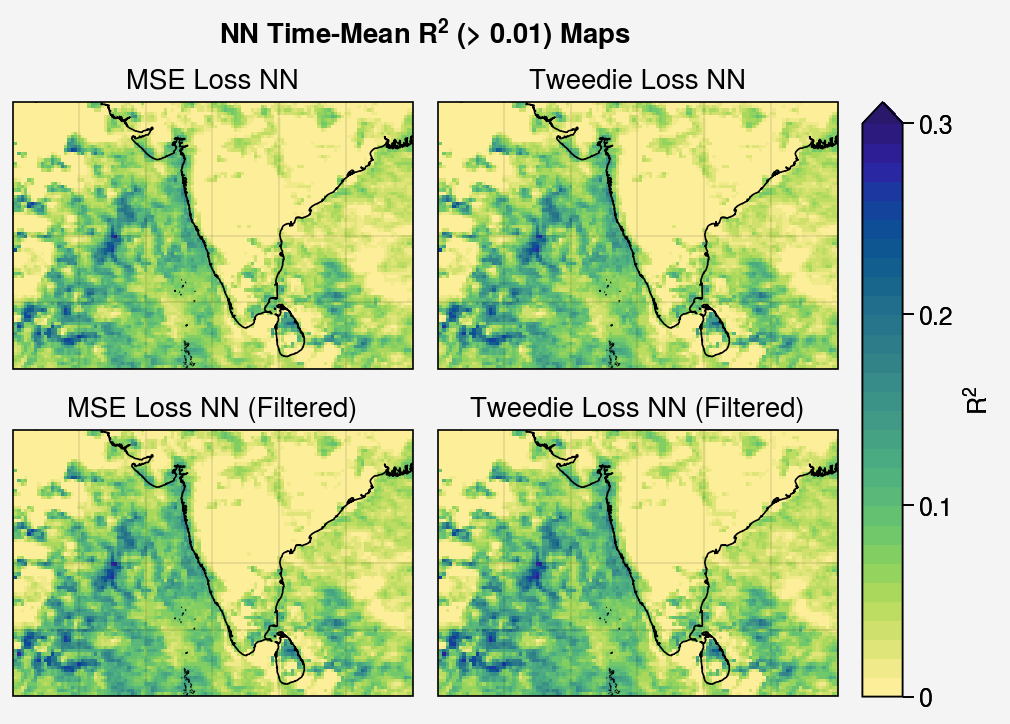

In [29]:
nnpaneldata = [t for t in paneldata if 'nn' in t[0].lower()]

fig,axs = pplt.subplots(nrows=2,ncols=2,refwidth=2,proj='cyl',share=False)
axs.format(suptitle=f'NN Time-Mean R$^2$ (> 0.01) Maps',
           coast=True,latlim=(5.,25.),latlines=[5,10,15],lonlim=(60.,90.),lonlines=5)

im = None
for ax,(description,r2) in zip(axs,nnpaneldata):
    im = ax.pcolormesh(r2.lon,r2.lat,r2,cmap='Haline_r',vmin=0,vmax=0.3,levels=30,extend='max')
    ax.format(title=description)

fig.colorbar(im,loc='r',label='R$^2$',ticks=0.1)
pplt.show()